# Global Mean EOF Analysis
Liam Kirkpatrick
ATM 552, Assignment 5
February 4, 2024

## Introduction

This code is modeled after Dennis Hartman's script on github (https://github.com/dennislhartmann/Objective_Analysis/tree/main).

## Import Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
from scipy.io import loadmat
from scipy.interpolate import griddata
import scipy.signal as sig
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import netCDF4 as nc
from cartopy import config
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## User Inputs

In [2]:
#  Global domain
lat1=88.
lat2=-88.
lon1=0.
lon2=360.

# set years to begin and end for climatology
yrbeg = 1900
yrend = 2023

#set the years for eof analysis
yra = yrbeg
yrb = yrend
cent_lon = -160.   # central longitude for Robinson maps

# behind the scenes bookkeeping on year selection
iyr1 = (yrbeg-1854)*12
iyr2 = (yrend - 1854 + 1)*12

# choices on removal
rem_trend = False
rem_globmean = False


In [3]:
## Import Data

ds = nc.Dataset('data/sst.mnmean.nc')
#print(ds)

# open using xarray
ds_disk = xr.open_dataset('data/sst.mnmean.nc') 
sst = ds_disk.sst   # not here prcp is actually sst
lon = ds_disk.lon
lat = ds_disk.lat

ds_disk

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2041, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-01-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-02-03

## Clean up Data

In [4]:
# extend longitude array
lonp = np.empty(len(lon)+1)
lonp[0:len(lon)] = lon
lonp[len(lon)]= lon[len(lon)-1]+lon[1]-lon[0]

# Calculate SST Mean
sstm = np.nanmean(sst,0)

# Here we are adding cyclic continuity to SST, so it plots without gaps
sstmp = np.empty([len(lat),len(lon)+1])
sstmp[:,0:len(lon)]= sstm
sstmp[:,len(lon+1)]= sstm[:,0]
xx = sstmp[:,0]
print('max sst',np.max(sstmp))
print('xx ',np.shape(xx))   #  This is likely NaN

# clip out years I want to consider
sst1 = sst[iyr1:iyr2,:,:]
print('sst clipped shape ',np.shape(sst))

max sst nan
xx  (89,)
sst clipped shape  (2041, 89, 180)


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_79053/223043069.py:7: RuntimeWarning: Mean of empty slice
  sstm = np.nanmean(sst,0)


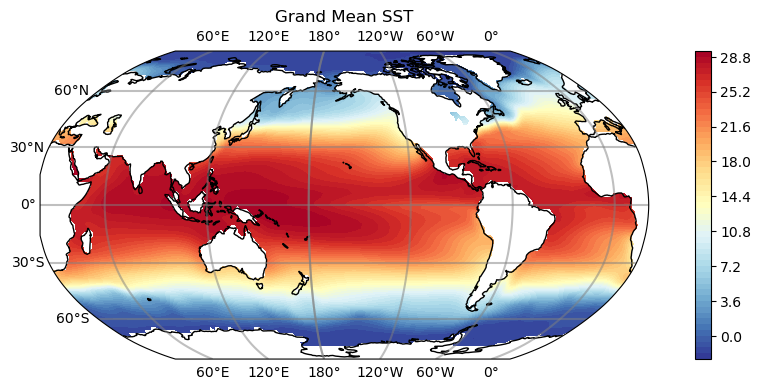

sst type  <class 'xarray.core.dataarray.DataArray'>


In [5]:
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu_r'

# make figure
plt.figure(figsize=(12, 4), dpi=100)

# set up axis. Use cent_lon set above
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')

# add color for sst
plt.contourf(lonp, lat, sstmp, 60, cmap=col_mapc,
             transform=ccrs.PlateCarree())

# Housekeeping
plt.title('Grand Mean SST')
ax.coastlines()
plt.grid()
plt.colorbar()
plt.show()
print('sst type ',type(sst))

## Remove Annual Cycle

Here we remvoe the annual cycle. 

In [6]:

sstx = xr.DataArray.to_numpy(sst1)  # transition to numpy space
latx=len(lat) 
lonx=len(lon)
print('latx ',type(latx))
print('sst shape ',np.shape(sstx))
print('type sst ',type(sstx))
sts = np.shape(sstx)
yrmx = int(sts[0]/12)
print('sts[0] = ',sts[0],'yrmx = ',yrmx)

# Now remove annual cycle from prcp
sstx = np.reshape(sstx,(yrmx,12,latx,lonx))
print('sstx shape ',np.shape(sstx))
sstm = np.nanmean(sstx,0)
print('sstm ',np.shape(sstm))
sstmx = np.max(sstm)
print('sstmx ',sstmx)

rem_ann = True
if rem_ann is True:
    # subtract mean from each month
    for i in range(0,yrmx):
        sstx[i,:,:,:] = sstx[i,:,:,:]-sstm

latx  <class 'int'>
sst shape  (1488, 89, 180)
type sst  <class 'numpy.ndarray'>
sts[0] =  1488 yrmx =  124
sstx shape  (124, 12, 89, 180)
sstm  (12, 89, 180)
sstmx  nan


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_79053/2874448381.py:14: RuntimeWarning: Mean of empty slice
  sstm = np.nanmean(sstx,0)


## Plot a monthly mean

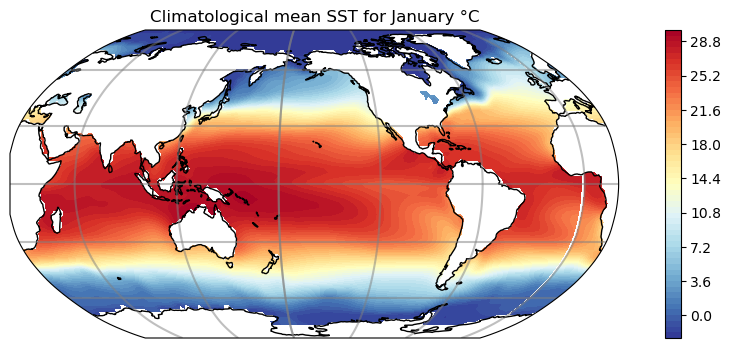

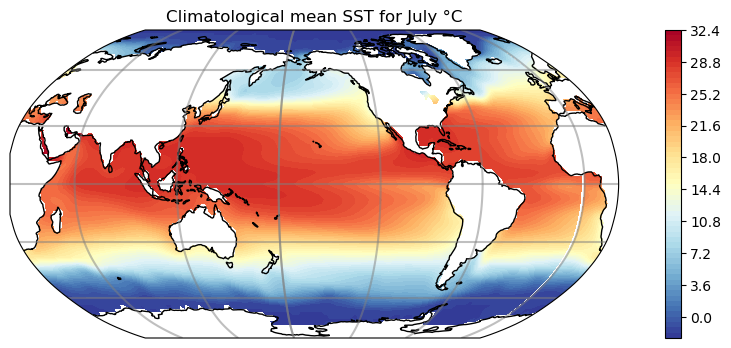

In [7]:
# let's try to plot a monthly mean
plt.figure(figsize=(12, 4), dpi=100)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))

plt.contourf(lon, lat, sstm[0,:,:], 60, cmap = col_mapc,
             transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
ax.coastlines()
plt.colorbar()

plt.title('Climatological mean SST for January \N{DEGREE SIGN}C')
#plt.colorbar(location='bottom')
plt.show()

plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))

plt.contourf(lon, lat, sstm[6,:,:], 60, cmap = col_mapc,
             transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
ax.coastlines()
plt.colorbar()

plt.title('Climatological mean SST for July \N{DEGREE SIGN}C')
#plt.colorbar(location='bottom')
plt.show()

## Pick subset of months / reigon for EOF Analysis

In [8]:
#  Specify the geographical boundaries and months we want to use
# let's experiment a bit with the xarray version
#sst  # this statement tells you what is in the structure sst 
#ssta = sst.sel(time=slice(1950-1-1, 2022-1-1),lon=slice(0., 90.),lat=slice(0., 89.))

yr1= str(yra)+'-01-01'
yr2= str(yrb)+'-12-31'
years = np.linspace(float(yra),float(yrb+1),num = (yrb-yra+1)*12)
print('size years',np.shape(years),yr1,yr2)

sst0 = sst.sel(time=slice(yr1, yr2),lat=slice(90., -90),lon=slice(0., 360.))

ssta = sst.sel(time=slice(yr1, yr2),lat=slice(lat1, lat2),lon=slice(lon1, lon2))
# here I think I am weighting the data array for sqrt(cosine(latitude) so area variance is used in EOF computation

lat_sh=ssta.lat
lon_sh=ssta.lon
print('lat_sh',np.shape(lat_sh))
cn = np.sqrt(np.cos(lat_sh*np.pi/180.))
#weights
#ssta_weighted = ssta.weighted(weights)
#type(ssta_weighted)
#print('ssta_weighted ',np.shape(ssta_weighted))
#sst0 = np.reshape(sst0,(mnx,latx,lonx))
print('shape ssta ',np.shape(ssta))
print(range(len(lat_sh)))

def globalmean(sst,cn,mnx,lat_sh):  # I have not finished or implemented removing the global mean from each month.
    for i in range(mnx):
        for j in range(len(lat_sh)):
            sst[i,j,:] = sst[i,j,:]*cn[j]  # times sqrt(cos(lat))
    gm = nanmean(sst,1)
    gm = nanmean(gm,1)
    return gm

if rem_globmean: 
    gm = globalmean(ssta,cn,mnx,lat_sh)
    print('gm = ',gm[0:12]) 
    
for i in range(len(lat_sh)):  # this loop weights ssta by our sqrt(cos(lat))
    ssta[:,i,:] = ssta[:,i,:]*cn[i]  # times sqrt(cos(lat))

size years (1488,) 1900-01-01 2023-12-31
lat_sh (89,)
shape ssta  (1488, 89, 180)
range(0, 89)


## Test plot to make sure  all is working



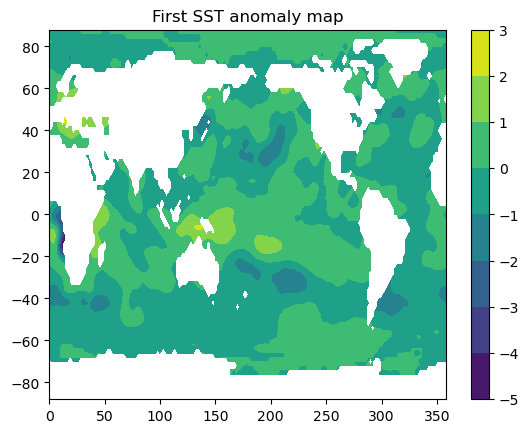

In [16]:
if True:
    plt.figure()
    plt.contourf(lon_sh,lat_sh,ssta[10,:,:]) 
    plt.title('First SST anomaly map')
    plt.colorbar()